In [4]:
from google.colab import files
print("Upload your kaggle.json file")
files.upload()

Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amulyavc","key":"fb07df1c0b236a210a513ff06062b2a6"}'}

In [5]:
# Make directory named kaggle and copy kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (replace with the correct dataset API command)
# You can find this command on the Kaggle dataset page under the "three dots" menu -> "Copy API command"
!kaggle datasets download -d dftow001/bottle-csv

# Unzip the downloaded file (Kaggle datasets are often zipped)
# The downloaded file might be named bottle-csv.zip or similar
!unzip -q bottle-csv.zip -d bottle_data
# Check the contents of the unzipped folder to find the exact CSV name
!ls bottle_data

Dataset URL: https://www.kaggle.com/datasets/dftow001/bottle-csv
License(s): unknown
  0% 0.00/48.2M [00:00<?, ?B/s]
100% 48.2M/48.2M [00:00<00:00, 2.00GB/s]
bottle.csv


In [7]:
!unzip bottle-csv.zip

Archive:  bottle-csv.zip
  inflating: bottle.csv              

In [8]:
import pandas as pd

df = pd.read_csv('bottle.csv')  # or the correct CSV file extracted
df_binary = df[['Salnty', 'T_degC']]
df_binary.columns = ['Sal', 'Temp']
df_binary.head()

,Sal,Temp
0,33.440,10.50
1,33.440,10.46
2,33.437,10.46
3,33.420,10.45
4,33.421,10.45


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
try:
    df = pd.read_csv('bottle_data/bottle.csv', low_memory=False) # low_memory=False to handle mixed types warning
    print("Dataset loaded successfully.")
    print(f"Original shape: {df.shape}")
except FileNotFoundError:
    print("Error: bottle.csv not found. Make sure the download and unzip steps were successful.")
    # You might need to adjust the path if it's different
    df = None # Set df to None if file not found

Dataset loaded successfully.
Original shape: (864863, 74)


In [10]:
if df is not None:
    # Select relevant features for our logistic regression demo
    # We'll use Salinity and Temperature
    df_subset = df[['Salnty', 'T_degC']].copy()
    df_subset.columns = ['Salinity', 'Temperature'] # Rename for clarity

    print("\nOriginal subset head:")
    print(df_subset.head())
    print(f"\nMissing values before handling:\n{df_subset.isnull().sum()}")

    # --- Handle Missing Values ---
    # For simplicity in this demo, we'll drop rows with NaNs in our selected columns
    # In a real project, you might consider imputation
    df_subset.dropna(inplace=True)
    print(f"\nShape after dropping NaNs: {df_subset.shape}")
    print(f"Missing values after handling:\n{df_subset.isnull().sum()}")

    # --- Create a Binary Target Variable ---
    # Let's create a target based on Temperature: e.g., 'High_Temp' if Temperature > median
    if not df_subset.empty:
        median_temp = df_subset['Temperature'].median()
        df_subset['High_Temp'] = (df_subset['Temperature'] > median_temp).astype(int) # 1 if high, 0 if low/medium
        print(f"\nMedian Temperature used for threshold: {median_temp:.2f}")
        print("\nSubset with target variable 'High_Temp':")
        print(df_subset.head())
        print("\nTarget variable distribution:")
        print(df_subset['High_Temp'].value_counts(normalize=True))
    else:
        print("DataFrame is empty after dropping NaNs. Cannot proceed.")
else:
    print("DataFrame not loaded. Cannot proceed with preprocessing.")


Original subset head:
   Salinity  Temperature
0    33.440        10.50
1    33.440        10.46
2    33.437        10.46
3    33.420        10.45
4    33.421        10.45

Missing values before handling:
Salinity       47354
Temperature    10963
dtype: int64

Shape after dropping NaNs: (814247, 2)
Missing values after handling:
Salinity       0
Temperature    0
dtype: int64

Median Temperature used for threshold: 10.11

Subset with target variable 'High_Temp':
   Salinity  Temperature  High_Temp
0    33.440        10.50          1
1    33.440        10.46          1
2    33.437        10.46          1
3    33.420        10.45          1
4    33.421        10.45          1

Target variable distribution:
High_Temp
0    0.5004
1    0.4996
Name: proportion, dtype: float64


In [11]:
if df is not None and not df_subset.empty and 'High_Temp' in df_subset.columns:
    X = df_subset[['Salinity', 'Temperature']]
    y = df_subset['High_Temp']

    # --- Split Data ---
    # For a large dataset, let's take a sample for faster training/plotting in the demo
    # You can adjust sample_frac or remove sampling for full dataset
    if len(df_subset) > 50000: # If dataset is still large
        df_sample = df_subset.sample(n=20000, random_state=42) # Sample 20k points
        X = df_sample[['Salinity', 'Temperature']]
        y = df_sample['High_Temp']
        print(f"\nUsing a sample of {len(df_sample)} for training/plotting.")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # --- Feature Scaling ---
    # Logistic Regression benefits from feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nShape of X_train: {X_train_scaled.shape}, Shape of y_train: {y_train.shape}")
    print(f"Shape of X_test: {X_test_scaled.shape}, Shape of y_test: {y_test.shape}")
else:
    print("Data not prepared. Cannot proceed with model training.")


Using a sample of 20000 for training/plotting.

Shape of X_train: (14000, 2), Shape of y_train: (14000,)
Shape of X_test: (6000, 2), Shape of y_test: (6000,)



--- Model Evaluation ---
Training Accuracy: 0.9966
Test Accuracy: 0.9985

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2999
           1       1.00      1.00      1.00      3001

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


Test Set Confusion Matrix:


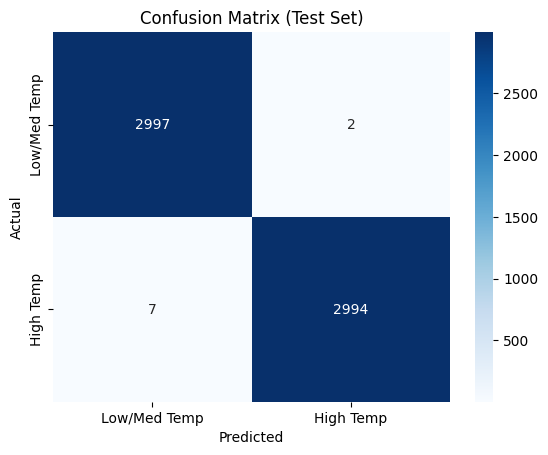

In [12]:
if 'X_train_scaled' in locals(): # Check if variables from previous cell exist
    model = LogisticRegression(solver='liblinear', random_state=42) # liblinear is good for smaller datasets
    model.fit(X_train_scaled, y_train)

    # --- Make Predictions ---
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # --- Evaluate Model ---
    print("\n--- Model Evaluation ---")
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred_test))

    print("\nTest Set Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low/Med Temp', 'High Temp'], yticklabels=['Low/Med Temp', 'High Temp'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
else:
    print("Training data not available. Cannot train model.")


--- Plotting Decision Boundary (using a sample of test data for clarity) ---


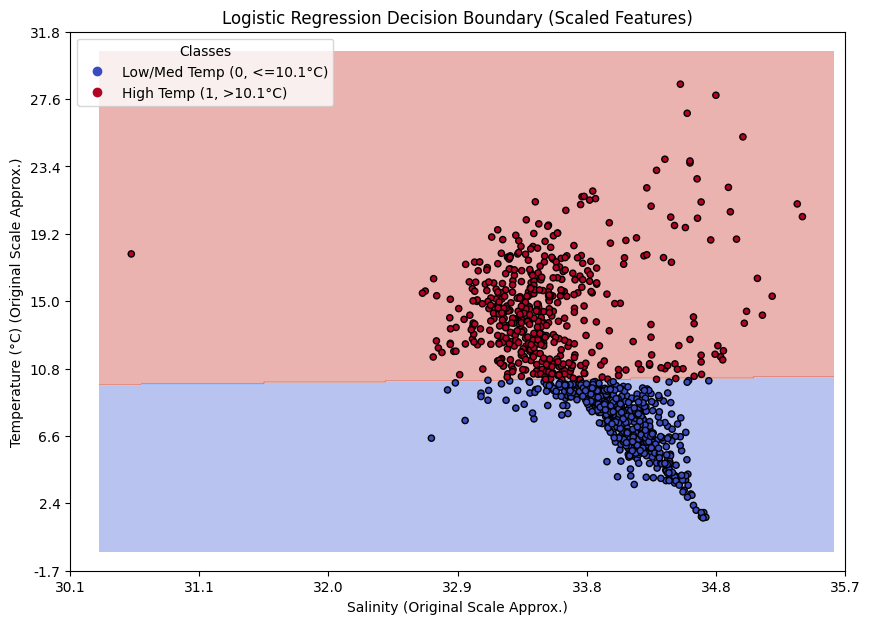

In [13]:
if 'model' in locals() and 'X_train' in locals(): # Check if model and data exist
    print("\n--- Plotting Decision Boundary (using a sample of test data for clarity) ---")

    # For plotting, it's better to use a smaller sample of the test set if it's large
    # to make the scatter plot less dense.
    # We'll plot the decision boundary on the SCALED features, then map axis ticks back.

    # Take a sample of the test data for plotting
    plot_sample_size = min(1000, len(X_test_scaled)) # Plot max 1000 points or all if less
    idx_sample = np.random.choice(X_test_scaled.shape[0], plot_sample_size, replace=False)
    X_test_sample_scaled = X_test_scaled[idx_sample, :]
    y_test_sample = y_test.iloc[idx_sample]


    # 1. Create a meshgrid of points in the scaled feature space
    x_min, x_max = X_test_sample_scaled[:, 0].min() - 0.5, X_test_sample_scaled[:, 0].max() + 0.5
    y_min, y_max = X_test_sample_scaled[:, 1].min() - 0.5, X_test_sample_scaled[:, 1].max() + 0.5
    h = 0.02  # step size in the mesh
    xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min, x_max, h),
                                       np.arange(y_min, y_max, h))

    # 2. Predict the class for each point in the meshgrid
    Z_scaled = model.predict(np.c_[xx_scaled.ravel(), yy_scaled.ravel()])
    Z_scaled = Z_scaled.reshape(xx_scaled.shape)

    # 3. Plot the decision boundary (contour) and the data points
    plt.figure(figsize=(10, 7))
    plt.contourf(xx_scaled, yy_scaled, Z_scaled, alpha=0.4, cmap=plt.cm.coolwarm)

    # Scatter plot of the (sampled) test data points
    # We need to plot the scaled data because the boundary is in scaled space
    scatter = plt.scatter(X_test_sample_scaled[:, 0], X_test_sample_scaled[:, 1], c=y_test_sample,
                          s=20, edgecolor='k', cmap=plt.cm.coolwarm)

    plt.title('Logistic Regression Decision Boundary (Scaled Features)')
    plt.xlabel('Scaled Salinity')
    plt.ylabel('Scaled Temperature')

    # Create a legend
    handles, labels = scatter.legend_elements()
    legend_labels = [f"Low/Med Temp (0, <={median_temp:.1f}°C)", f"High Temp (1, >{median_temp:.1f}°C)"]
    if len(handles) == len(legend_labels): # Check if both classes are present in sample
         plt.legend(handles, legend_labels, title="Classes")
    elif len(handles) == 1 and y_test_sample.nunique() == 1: # Only one class in sample
        class_present = y_test_sample.unique()[0]
        plt.legend([handles[0]], [legend_labels[class_present]], title="Class Present")

    # --- Optional: Try to map axis ticks back to original scale for better interpretation ---
    # This is an approximation as the boundary is linear in scaled space, not necessarily original.
    # Get some tick values in scaled space
    x_ticks_scaled = plt.xticks()[0]
    y_ticks_scaled = plt.yticks()[0]

    # Inverse transform them
    # For x_ticks (Salinity): need an array like [[tick1, mean_temp_scaled], [tick2, mean_temp_scaled], ...]
    # For y_ticks (Temperature): need an array like [[mean_sal_scaled, tick1], [mean_sal_scaled, tick2], ...]
    mean_temp_scaled_for_x_ticks = np.full_like(x_ticks_scaled, X_train_scaled[:, 1].mean())
    x_ticks_original = scaler.inverse_transform(np.column_stack((x_ticks_scaled, mean_temp_scaled_for_x_ticks)))[:, 0]

    mean_sal_scaled_for_y_ticks = np.full_like(y_ticks_scaled, X_train_scaled[:, 0].mean())
    y_ticks_original = scaler.inverse_transform(np.column_stack((mean_sal_scaled_for_y_ticks, y_ticks_scaled)))[:, 1]

    # Set the new tick labels
    # Filter out NaNs that might occur if ticks are outside original data range after inverse transform
    valid_x_indices = ~np.isnan(x_ticks_original)
    valid_y_indices = ~np.isnan(y_ticks_original)

    if np.any(valid_x_indices):
        plt.xticks(x_ticks_scaled[valid_x_indices], [f"{val:.1f}" for val in x_ticks_original[valid_x_indices]])
        plt.xlabel('Salinity (Original Scale Approx.)')
    if np.any(valid_y_indices):
        plt.yticks(y_ticks_scaled[valid_y_indices], [f"{val:.1f}" for val in y_ticks_original[valid_y_indices]])
        plt.ylabel('Temperature (°C) (Original Scale Approx.)')


    plt.show()

else:
    print("Model or data not available for plotting.")